Raw dataset: 50694 rows and 29 columns
Created date column from year, month, and day columns
Converted spend_retail_w_grocery from string to numeric
Converted spend_grf from string to numeric
Converted spend_sgh from string to numeric
Converted spend_durables from string to numeric
Converted spend_apg from string to numeric
Converted spend_inpersonmisc from string to numeric
Converted spend_remoteservices from string to numeric
Converted spend_all_q1 from string to numeric
Converted spend_all_q4 from string to numeric
Converted spend_all from string to numeric
Filled 1644 missing values in spend_retail_w_grocery
Filled 1644 missing values in spend_grf
Filled 1644 missing values in spend_sgh
Filled 1644 missing values in spend_durables
Filled 1644 missing values in spend_apg
Filled 1644 missing values in spend_inpersonmisc
Filled 1644 missing values in spend_remoteservices
Filled 4587 missing values in spend_all_q1
Filled 3606 missing values in spend_all_q4
Filled 1644 missing values in

,Category,Type,Q1 Mean,Q4 Mean,Difference,t-test p-value,Cohen's d,Effect Size,Significance
2,spend_sgh,Essential,0.3728,0.2733,0.0995,0.32947,0.008,Negligible,Not Significant
4,spend_apg,Non-Essential,0.2850,0.1985,0.0866,0.03207,0.017,Negligible,*
5,spend_inpersonmisc,Non-Essential,0.1301,0.0578,0.0723,0.00285,0.024,Negligible,**
8,All Non-Essential,Non-Essential,0.2109,0.1402,0.0707,0.00001,0.035,Negligible,**
7,All Essential,Essential,0.2525,0.1830,0.0695,0.11577,0.012,Negligible,Not Significant
0,spend_retail_w_grocery,Essential,0.2312,0.1642,0.0670,0.00662,0.021,Negligible,*
6,spend_remoteservices,Non-Essential,0.2270,0.1631,0.0639,0.00000,0.052,Negligible,**
3,spend_durables,Non-Essential,0.2016,0.1415,0.0601,0.01435,0.019,Negligible,*
1,spend_grf,Essential,0.1535,0.1114,0.0421,0.00001,0.035,Negligible,**


- 3 out of 9 categories show uncorrected significance (p < 0.05)
- 4 categories remain significant after Bonferroni correction (p < 0.00556)


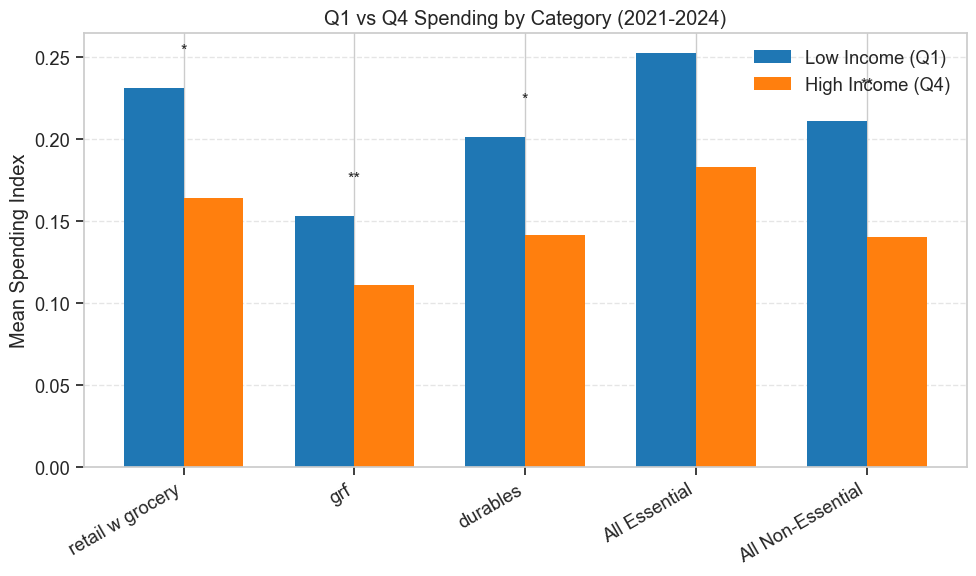

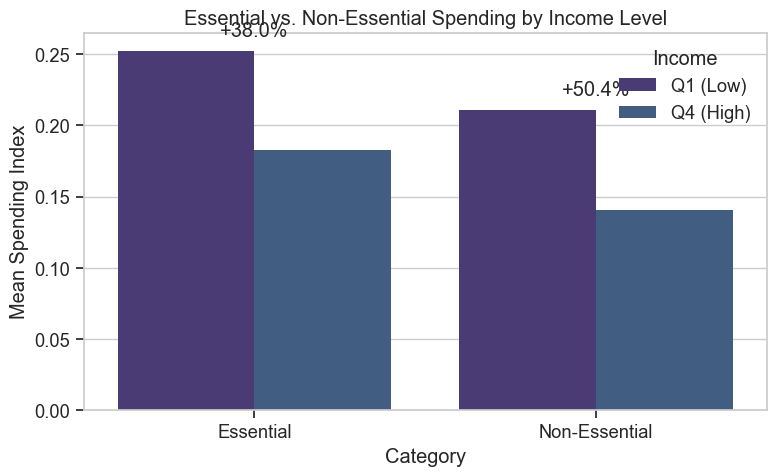

,Category,Type,Q1 Mean,Q4 Mean,Difference,t-test p-value,Cohen's d,Effect Size,Significance
2,spend_sgh,Essential,0.3728,0.2733,0.0995,0.32947,0.008,Negligible,Not Significant
4,spend_apg,Non-Essential,0.2850,0.1985,0.0866,0.03207,0.017,Negligible,*
5,spend_inpersonmisc,Non-Essential,0.1301,0.0578,0.0723,0.00285,0.024,Negligible,**
8,All Non-Essential,Non-Essential,0.2109,0.1402,0.0707,0.00001,0.035,Negligible,**
7,All Essential,Essential,0.2525,0.1830,0.0695,0.11577,0.012,Negligible,Not Significant
0,spend_retail_w_grocery,Essential,0.2312,0.1642,0.0670,0.00662,0.021,Negligible,*
6,spend_remoteservices,Non-Essential,0.2270,0.1631,0.0639,0.00000,0.052,Negligible,**
3,spend_durables,Non-Essential,0.2016,0.1415,0.0601,0.01435,0.019,Negligible,*
1,spend_grf,Essential,0.1535,0.1114,0.0421,0.00001,0.035,Negligible,**


In [9]:
# CHUNK 1: IMPORTS AND SETUP
# ==========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set aesthetic parameters for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
sns.set_context("notebook", font_scale=1.2)

# CHUNK 2: LOAD AND PREPARE DATA
# =============================
# Load the dataset
df = pd.read_excel("D:/capstone/datasets/Affinity - State - Daily.xlsx")
print(f"Raw dataset: {df.shape[0]} rows and {df.shape[1]} columns")

# Create date column if it doesn't exist
if 'date' not in df.columns:
    if all(col in df.columns for col in ['year', 'month', 'day']):
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
        print("Created date column from year, month, and day columns")

# Define spending categories
essential_categories = ['spend_retail_w_grocery', 'spend_grf', 'spend_sgh']
non_essential_categories = ['spend_durables', 'spend_apg', 'spend_inpersonmisc', 'spend_remoteservices']
income_columns = ['spend_all_q1', 'spend_all_q4', 'spend_all'] 

# Convert columns to numeric
all_columns = essential_categories + non_essential_categories + income_columns
for col in all_columns:
    if col in df.columns:
        if df[col].dtype == 'object':
            df[col] = pd.to_numeric(df[col], errors='coerce')
            print(f"Converted {col} from string to numeric")

# Handle missing values
for col in essential_categories + non_essential_categories + income_columns:
    if col in df.columns and df[col].isna().sum() > 0:
        missing_count = df[col].isna().sum()
        df[col] = df[col].fillna(df[col].median())
        print(f"Filled {missing_count} missing values in {col}")

# Filter for recovery phase (Jan 2021 onward)
df_recovery = df[df['date'] >= '2021-01-01'].copy()
print(f"Recovery dataset: {len(df_recovery)} rows from {df_recovery['date'].min().strftime('%Y-%m-%d')} to {df_recovery['date'].max().strftime('%Y-%m-%d')}")

# CHUNK 3: COMPUTE INCOME-LEVEL CATEGORY SPENDING
# ==============================================
# Create derived columns for each category by income level
print("Creating income-weighted category columns...")
for category in essential_categories + non_essential_categories:
    # Handle division by zero
    denominator = df_recovery['spend_all'].replace(0, np.nan)
    
    # Create derived columns safely
    df_recovery[f"{category}_q1"] = (df_recovery[category] * df_recovery['spend_all_q1']).div(denominator)
    df_recovery[f"{category}_q4"] = (df_recovery[category] * df_recovery['spend_all_q4']).div(denominator)

# Calculate aggregated essential and non-essential spending
df_recovery['essential_q1'] = df_recovery[[f"{cat}_q1" for cat in essential_categories]].mean(axis=1)
df_recovery['essential_q4'] = df_recovery[[f"{cat}_q4" for cat in essential_categories]].mean(axis=1)
df_recovery['non_essential_q1'] = df_recovery[[f"{cat}_q1" for cat in non_essential_categories]].mean(axis=1)
df_recovery['non_essential_q4'] = df_recovery[[f"{cat}_q4" for cat in non_essential_categories]].mean(axis=1)

# Show aggregated means
print(f"Essential Q1 mean: {df_recovery['essential_q1'].mean():.4f}")
print(f"Essential Q4 mean: {df_recovery['essential_q4'].mean():.4f}")
print(f"Non-Essential Q1 mean: {df_recovery['non_essential_q1'].mean():.4f}")
print(f"Non-Essential Q4 mean: {df_recovery['non_essential_q4'].mean():.4f}")

# CHUNK 4: STATISTICAL TESTING FUNCTION
# ====================================
def run_statistical_tests(q1_data, q4_data, category_name, category_type):
    """Perform statistical tests comparing Q1 and Q4 spending for a category"""
    # Clean data 
    q1_clean = q1_data.dropna()
    q4_clean = q4_data.dropna()
    
    # Calculate basic stats
    q1_mean = q1_clean.mean()
    q4_mean = q4_clean.mean() 
    difference = q1_mean - q4_mean
    
    # T-test (Welch's t-test: doesn't assume equal variance)
    t_stat, p_value = stats.ttest_ind(q1_clean, q4_clean, equal_var=False)
    
    # Wilcoxon test (for paired/related samples)
    try:
        min_len = min(len(q1_clean), len(q4_clean))
        w_stat, w_p_value = stats.wilcoxon(q1_clean[:min_len], q4_clean[:min_len])
    except:
        w_stat, w_p_value = np.nan, np.nan
    
    # Calculate Cohen's d (effect size)
    n1, n4 = len(q1_clean), len(q4_clean)
    if n1 > 0 and n4 > 0:
        s1, s4 = q1_clean.std(), q4_clean.std()
        # Weighted pooled SD formula
        pooled_std = np.sqrt(((n1-1)*(s1**2) + (n4-1)*(s4**2)) / (n1+n4-2))
        cohens_d = difference / pooled_std if pooled_std != 0 else np.nan
    else:
        cohens_d = np.nan
    
    # Effect size interpretation
    if abs(cohens_d) < 0.2:
        effect_size = "Negligible"
    elif abs(cohens_d) < 0.5:
        effect_size = "Small"
    elif abs(cohens_d) < 0.8:
        effect_size = "Medium"
    else:
        effect_size = "Large"
    
    # Return results as dictionary
    return {
        "Category": category_name,
        "Type": category_type,
        "Q1 Mean": q1_mean,
        "Q4 Mean": q4_mean,
        "Difference": difference,
        "t-statistic": t_stat,
        "t-test p-value": p_value,
        "Wilcoxon p-value": w_p_value,
        "Cohen's d": cohens_d,
        "Effect Size": effect_size,
        "Higher Spending": "Q1" if q1_mean > q4_mean else "Q4"
    }

# CHUNK 5: ANALYZE ALL CATEGORIES
# ==============================
# Set up all categories to analyze
all_categories = []
for cat in essential_categories:
    all_categories.append({"name": cat, "type": "Essential"})
for cat in non_essential_categories:
    all_categories.append({"name": cat, "type": "Non-Essential"})

# Add aggregated categories
all_categories.append({"name": "All Essential", "type": "Essential"})
all_categories.append({"name": "All Non-Essential", "type": "Non-Essential"})

# Run tests for each category
results = []
for category in all_categories:
    category_name = category["name"]
    category_type = category["type"]
    
    # Get data for this category
    if category_name == "All Essential":
        q1_data = df_recovery['essential_q1']
        q4_data = df_recovery['essential_q4']
    elif category_name == "All Non-Essential":
        q1_data = df_recovery['non_essential_q1']
        q4_data = df_recovery['non_essential_q4']
    else:
        q1_data = df_recovery[f"{category_name}_q1"]
        q4_data = df_recovery[f"{category_name}_q4"]
    
    # Run tests and store results
    print(f"Testing {category_type}: {category_name}")
    result = run_statistical_tests(q1_data, q4_data, category_name, category_type)
    results.append(result)

# CHUNK 6: CREATE RESULTS TABLE WITH BONFERRONI CORRECTION
# ======================================================
# Create dataframe and apply Bonferroni correction
results_df = pd.DataFrame(results)
alpha = 0.05
alpha_corrected = alpha / len(results_df)  # Bonferroni correction
results_df['Significance'] = 'Not Significant'
results_df.loc[results_df['t-test p-value'] < alpha, 'Significance'] = '*'
results_df.loc[results_df['t-test p-value'] < alpha_corrected, 'Significance'] = '**'

# Create summary table
summary_table = results_df[['Category', 'Type', 'Q1 Mean', 'Q4 Mean', 'Difference', 
                           't-test p-value', 'Cohen\'s d', 'Effect Size', 'Significance']]
summary_table = summary_table.sort_values(by='Difference', key=abs, ascending=False)
summary_table = summary_table.round({
    'Q1 Mean': 4, 
    'Q4 Mean': 4, 
    'Difference': 4, 
    't-test p-value': 5, 
    'Cohen\'s d': 3
})

# Display summary table
print("\nResults (sorted by difference magnitude):")
display(summary_table)

# Count significant results
sig_count = (results_df['Significance'] == '*').sum()
sig_corrected_count = (results_df['Significance'] == '**').sum()
print(f"- {sig_count} out of {len(results_df)} categories show uncorrected significance (p < {alpha})")
print(f"- {sig_corrected_count} categories remain significant after Bonferroni correction (p < {alpha_corrected:.5f})")

# CHUNK 7: VISUALIZE KEY FINDINGS
# =============================
# 1. Bar chart comparing income levels across categories
plt.figure(figsize=(10, 6))
# Filter to most important categories for clarity
important_cats = ['All Essential', 'All Non-Essential', 'spend_retail_w_grocery', 'spend_grf', 'spend_durables']
plot_data = results_df[results_df['Category'].isin(important_cats)]

# Set up bar chart
categories = plot_data['Category'].tolist()
q1_means = plot_data['Q1 Mean'].tolist()
q4_means = plot_data['Q4 Mean'].tolist()
x = np.arange(len(categories))
width = 0.35

plt.bar(x - width/2, q1_means, width, label='Low Income (Q1)', color='#1f77b4')
plt.bar(x + width/2, q4_means, width, label='High Income (Q4)', color='#ff7f0e')

# Add significance markers
for i, row in plot_data.reset_index().iterrows():
    if row['Significance'] != 'Not Significant':
        higher = max(q1_means[i], q4_means[i])
        plt.text(i, higher + 0.02, row['Significance'], ha='center', fontsize=12)

# Format chart
plt.ylabel('Mean Spending Index')
plt.title('Q1 vs Q4 Spending by Category (2021-2024)')
plt.xticks(x, [c.replace('spend_', '').replace('_', ' ') if 'spend_' in c else c for c in categories], 
           rotation=30, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# CHUNK 8: ESSENTIAL VS NON-ESSENTIAL COMPARISON
# ============================================
# Create a comparison of essential vs non-essential spending by income level
plt.figure(figsize=(8, 5))

# Prepare data for plotting
agg_data = pd.DataFrame({
    'Category': ['Essential', 'Essential', 'Non-Essential', 'Non-Essential'],
    'Income': ['Q1 (Low)', 'Q4 (High)', 'Q1 (Low)', 'Q4 (High)'],
    'Mean': [df_recovery['essential_q1'].mean(), df_recovery['essential_q4'].mean(),
            df_recovery['non_essential_q1'].mean(), df_recovery['non_essential_q4'].mean()]
})

# Create bar chart
sns.barplot(x='Category', y='Mean', hue='Income', data=agg_data)

# Add percentage differences
ess_diff = ((agg_data['Mean'][0] - agg_data['Mean'][1]) / agg_data['Mean'][1] * 100)
non_ess_diff = ((agg_data['Mean'][2] - agg_data['Mean'][3]) / agg_data['Mean'][3] * 100)
plt.text(0, agg_data['Mean'][0] + 0.01, f"+{ess_diff:.1f}%", ha='center')
plt.text(1, agg_data['Mean'][2] + 0.01, f"+{non_ess_diff:.1f}%", ha='center')

plt.title('Essential vs. Non-Essential Spending by Income Level')
plt.ylabel('Mean Spending Index')
plt.tight_layout()
plt.show()

# CHUNK 9: STYLED SUMMARY TABLE (OPTIONAL)
# =======================================
# Create a styled version of the summary table for better presentation
try:
    styled_summary = summary_table.style.background_gradient(
        subset=['Difference'], cmap='RdBu_r', vmin=-0.1, vmax=0.1
    ).format({
        'Q1 Mean': '{:.4f}',
        'Q4 Mean': '{:.4f}',
        'Difference': '{:.4f}',
        't-test p-value': '{:.5f}',
        'Cohen\'s d': '{:.3f}'
    }).set_caption("Table 1: Income-Level Differences in Essential vs. Non-Essential Spending")
    
    display(styled_summary)
except:
    # Fallback if styling doesn't work
    print("Styled table not available - using regular table instead")
    display(summary_table)